# Idealized entrainment

This notebook visualizes the results of GOTM simulations in an idealized wind stress-driven entrainment case with no rotation, in which the mixed layer gradually entrains into an underlying non-turbulent region with constant stable stratification.
The results are compared with the scaling derived from laboratory experiments of [Price (1979)](https://doi.org/10.1017/S0022112079002366), in which the time evolution of the mixed layer depth follows

$h_m(t) = (2R_v)^{1/4}u_*\left(\frac{t}{N_0}\right)^{1/2}$

where $R_v\approx0.6$ is the bulk Richardson number, $u_*$ the water side surface friction velocity, $N_0$ the initial buoyancy frequency.
See, e.g., section 5.1 of [Umlauf and Burchard (2005)](https://doi.org/10.1016/j.csr.2004.08.004) for more details.

In [1]:
import sys
import numpy as np
import string
import matplotlib.pyplot as plt
# add the path of gotmtool
sys.path.append("../gotmtool")
from gotmtool import *
from gotmtool.diags import *

## Load data

First, store the information of the four simulations into lists and dictionaries. 

In [2]:
runlabel = '_Nz250_Nt18000'
casenames = [
    'GLS-C01A'   + runlabel,
    'KPP-CVMix'  + runlabel,
    'KPPLT-VR12' + runlabel,
    'KPPLT-LF17' + runlabel,
    ]

labels = {
    casenames[0]: 'GLS-C01A',
    casenames[1]: 'KPP-CVMix',
    casenames[2]: 'KPPLT-VR12',
    casenames[3]: 'KPPLT-LF17',
    }

colors = {
    casenames[0]: 'tab:blue',
    casenames[1]: 'tab:olive',
    casenames[2]: 'tab:orange',
    casenames[3]: 'tab:red',
    }

linestyles = {
    casenames[0]: '-',
    casenames[1]: '-',
    casenames[2]: '-',
    casenames[3]: '-',
    }

casedir = '../gotm/run/Entrainment'
save_fig = True

Load data for the four simulations into a dictionary.

In [3]:
sims = {}
dataset = {}
for case in casenames:
    sim = Simulation(path=casedir+'/'+case)
    sims[case] = sim
    dataset[case] = sim.load_data()

## Figure 1

Vertical profiles of (a) down-wind velocity $u$, (b) turbulent viscosity $\nu_m$, and (c) squared buoyancy frequency $N^2$ at the end of the 30-hour simulations.

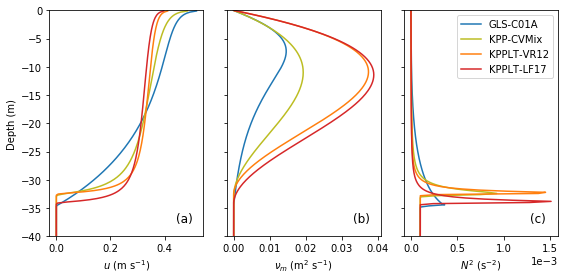

In [4]:
fig, axarr = plt.subplots(1,3, sharey='row')
fig.set_size_inches([8,4])
for case in casenames:
    data = dataset[case]
    data.u[:,-1,0,0].plot(y='z', ax=axarr[0], color=colors[case])
    data.num[:,-1,0,0].plot(y='zi', ax=axarr[1], color=colors[case])
    data.NN[:,-1,0,0].plot(y='zi', ax=axarr[2], color=colors[case], label=labels[case])

for i in np.arange(3):
    axarr[i].set_title('') 
    axarr[i].set_ylabel('') 
    
axarr[0].set_ylim([-40,0])
axarr[0].set_ylabel('Depth (m)')
axarr[0].set_xlabel('$u$ (m s$^{-1}$)')
axarr[1].set_xlabel('$\\nu_m$ (m$^2$ s$^{-1}$)')
axarr[2].set_xlabel('$N^2$ (s$^{-2}$)')
axarr[2].ticklabel_format(axis="x", style="sci", scilimits=(-2,2))

axarr[2].legend(loc='upper right')

for i, ax in enumerate(axarr):
    ax.text(0.82, 0.05, '('+string.ascii_lowercase[i]+')', transform=ax.transAxes,
            fontsize=12, va='bottom')

if save_fig:
    plt.tight_layout()
    figname = 'entrainment_pfl.pdf'
    fig.savefig(figname, dpi=300)

## Figure 2

A comparison of the time evolution of the mixed layer depth $h_m$ in GOTM simulations defined by the depth at which $N^2$ reaches its maximum in color, and the prediction of [Price (1979)](https://doi.org/10.1017/S0022112079002366) in black.

First, compute the predicted mixed layer depth.

In [5]:
data0 = dataset[casenames[0]]
N0 = np.sqrt(data0.NN[2,-1,0,0].values)
ustar = data0.u_taus[-1,0,0].values
sec = ((data0.time - data0.time[0])/np.timedelta64(1, 's')).values
mld_val = np.sqrt(np.sqrt(2.*0.6))*ustar*np.sqrt(sec/N0)
mld_p79 = xr.DataArray(mld_val, dims=['time'], coords={'time': data0.time},  
                  attrs={'long_name': 'mixed layer depth (Price 1979)',
                        'units': 'm'})

Then, plot the figure. See also Fig. 5a of [Umlauf and Burchard (2005)](https://doi.org/10.1016/j.csr.2004.08.004).

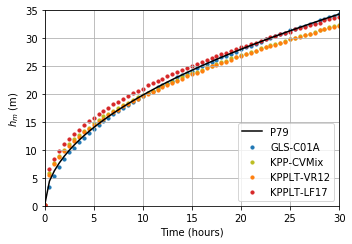

In [6]:
fig = plt.figure(figsize=[5,3.5])
hours = sec/3600.
plt.plot(hours, mld_p79.values, color='k', linestyle='-', linewidth=1.5, label='P79')
for case in casenames:
    data = dataset[case]
    NN = data.NN[:,:,0,0]
    mld = get_bld_maxNN(NN)
#     plt.plot(hours, mld.values, color=colors[case], linestyle=linestyles[case], label=labels[case])
    plt.scatter(hours, mld.values, s=10, color=colors[case], label=labels[case])
plt.ylabel('$h_m$ (m)')
plt.xlabel('Time (hours)')
plt.xlim([hours[0], hours[-1]])
plt.ylim([0,35])
plt.legend(loc='lower right')
plt.grid()
if save_fig:
    plt.tight_layout()
    figname = 'entrainment_ts.pdf'
    fig.savefig(figname, dpi=300)